<a href="https://colab.research.google.com/github/Amine-OMRI/-Transfer_learning_Resnet34_and_NasNetMobile/blob/master/transfert_learning_NasNetMobile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NasNetMobile**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
pip install -U image-classifiers==0.2.2

In [0]:
pip install image-classifiers==1.0.0

In [0]:
pip install git+https://github.com/qubvel/classification_models.git

In [0]:
import keras
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D, Flatten
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.optimizers import SGD
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from classification_models.keras import Classifiers
from imutils import paths   
import numpy as np
import pickle
import random
import os

In [0]:
# definir des nom des repertoires train, et test
TRAIN = "Trunk12_crops_train"
TEST = "Trunk12_crops_test"
# labels des classes
CLASSES = ["alder", "beech","birch","chestnut","ginkgobiloba","hornbeam","horsechestnut","linden","oak","orientalplane","pine","spruce"]

# taille du  batch
BATCH_SIZE = 16

# reprertoire original de la base de données
BASE_PATH = "/content/drive/My Drive/Trunk12_crops"
#"/content/Data/AFF11_resized"

# repertoire de sauvegarde du modele apres entrainement
mNasNet_save_model_FINE_TUNING = 'mNasNet Model FINE TUNING.model' 
MODEL_PATH_FINE_TUNING = F"/content/drive/My Drive/NasNet Models/{mNasNet_save_model_FINE_TUNING}"

mNasNet_save_model_WITHOUT_FIRST_BLOC = 'mNasNet Model WITHOUT FIRST BLOC.model' 
MODEL_PATH_WITHOUT_FIRST_BLOC = F"/content/drive/My Drive/NasNet Models/{mNasNet_save_model_WITHOUT_FIRST_BLOC}"

mNasNet_save_model_WITHOUT_TWO_FIRST_BLOC = 'mNasNet Model WITHOUT TWO FIRST BLOC.model' 
MODEL_PATH_WITHOUT_TWO_FIRST_BLOC = F"/content/drive/My Drive/NasNet Models/{mNasNet_save_model_WITHOUT_TWO_FIRST_BLOC}"

# repertoire ou sauvegarder le fichier CSV 
BASE_CSV_PATH = "/content/drive/My Drive/NasNet Models/feature_descriptors"

# graphe d'historique d'entrainement
mNasNet_Model_trainnig_graphe = 'NasNet Models_Model_trainnig_graphe.png'
TRAIN_ALL_PLOT_PATH = F"/content/drive/My Drive/NasNet Models/{mNasNet_Model_trainnig_graphe}"


TRAINING_HISTORY_PLOT_NEW_FC_FINE_TUNING = 'NasNetMobile_NEW_FC_FINE_TUNING.png'
TRAINING_HISTORY_PLOT_NEW_FC_FINE_TUNING = F"/content/drive/My Drive/NasNet Models/{TRAINING_HISTORY_PLOT_NEW_FC_FINE_TUNING}"

TRAINING_HISTORY_PLOT_WITHOUT_FIRST_BLOC = 'NasNetMobile_WITHOUT_FIRST_BLOC.png'
TRAINING_HISTORY_PLOT_PATH_WITHOUT_FIRST_BLOC = F"/content/drive/My Drive/NasNet Models/{TRAINING_HISTORY_PLOT_WITHOUT_FIRST_BLOC}"

TRAINING_HISTORY_PLOT_WITHOUT_TWO_FIRST_BLOC = 'NasNetMobile_WITHOUT_TWO_FIRST_BLOC.png'
TRAINING_HISTORY_PLOT_PATH_WITHOUT_TWO_FIRST_BLOC = F"/content/drive/My Drive/NasNet Models/{TRAINING_HISTORY_PLOT_WITHOUT_TWO_FIRST_BLOC}"


In [0]:
# fonction qui dessine les graphes de l'historique d'entrainement
def plot_training(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()
    plt.savefig(plotPath)
# chemins vers les repertoires train, val et test
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
#trainPath ="/content/Data/AFF11_resized/AFF11_resized_train"
# valPath = os.path.sep.join([config.BASE_PATH, config.VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])
#testPath ="/content/Data/AFF11_resized/AFF11_resized_test"

# nbr total des image dans chacun des repo train test
totalTrain = len(list(paths.list_images(trainPath)))
# totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))



print(testPath)
print(trainPath)

print(totalTest)
print(totalTrain)

In [0]:
# instancier un objet ImageDataGenerator pour l'augmentation des donnees train
trainAug = ImageDataGenerator(
    #featurewise_std_normalisation = True,
    rescale=1.0/255.0,
    horizontal_flip=True
    )

# instancier un objet ImageDataGenerator pour l'augmentation des donnees test
testAug = ImageDataGenerator(
    #featurewise_std_normalisation = True
    rescale=1.0/255.0
)


# initialiser le generateur de train
train_iterator = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)


# initialiser le generateur de test
test_iterator = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)


Found 2682 images belonging to 12 classes.
Found 2493 images belonging to 12 classes.


In [0]:
# charger le model NasNetMobile pre-entrainer sur imagenet et sans la derniere FC: ceci forme la partie basale du modele
NasNetMobile, preprocess_input = Classifiers.get('nasnetmobile')
baseModel_NasNetMobile = NasNetMobile(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
baseModel_NasNetMobile.summary()

In [0]:
print(len(baseModel_NasNetMobile.layers))

769


In [0]:
# construire une nouvelle couche FC  avec le nombre de classe de la nouvelle base:
# ceci forme le partie superieure du modele

def define_model_NasNetMobile():
  headModel = baseModel_NasNetMobile.output
  headModel = GlobalAveragePooling2D(name = "GlobalAveragePooling2D_1")(headModel)
  headModel = Dense(len(CLASSES), name = "Prediction")(headModel)
  
  # joindre les deux parties pour former le nouveau modele à entrainer
  # voir l'image "vgg-finetuning_FC.png"
  model = Model(inputs=baseModel_NasNetMobile.input, outputs=headModel)
  # geler (ou bien freeze) toute les couche basale du modèle, càd on ne va pas changer leur poids mais laisser les poids
  # appris sur imagenet
  for layer in baseModel_NasNetMobile.layers:
    layer.trainable = False

  return model

In [0]:
NasNetMobile_fine_tuned = define_model_NasNetMobile()
NasNetMobile_fine_tuned.summary()
# compiler le nouveau modele
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
NasNetMobile_fine_tuned.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [0]:
# entrainer la couche FC pour 50 epoch (rappel: toutes les autres couches sont gelees donc leurs poids resteront
# inchangés
print("[INFO] training head...")
H = NasNetMobile_fine_tuned.fit_generator(train_iterator, steps_per_epoch=totalTrain // BATCH_SIZE,
                        validation_data=test_iterator,
                        validation_steps=totalTest // BATCH_SIZE,
                        epochs=150)


[INFO] evaluating after fine-tuning network head...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        alder       0.00      0.00      0.00       189
        beech       0.17      0.01      0.02       243
        birch       0.00      0.00      0.00       162
     chestnut       0.16      0.91      0.28       378
 ginkgobiloba       0.00      0.00      0.00       144
     hornbeam       0.00      0.00      0.00       252
horsechestnut       0.00      0.00      0.00       171
       linden       0.00      0.00      0.00       135
          oak       0.00      0.00      0.00       135
orientalplane       0.00      0.00      0.00       189
         pine       0.21      0.23      0.22       189
       spruce       0.20      0.05      0.08       306

     accuracy                           0.16      2493
    macro avg       0.06      0.10      0.05      2493
 weighted avg       0.08      0.16      0.07      2493



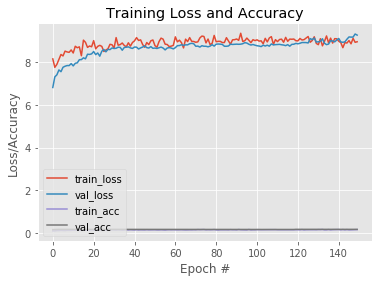

<Figure size 432x288 with 0 Axes>

In [0]:
# Evaluer le modele juste apres avoir entrainer la nouvelle FC
print("[INFO] evaluating after fine-tuning network head...")
test_iterator.reset()
predIdxs = NasNetMobile_fine_tuned.predict_generator(test_iterator, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
# afficher les performances de classification
print(classification_report(test_iterator.classes, predIdxs, target_names=test_iterator.class_indices.keys()))
plot_training(H, 150, TRAINING_HISTORY_PLOT_NEW_FC_FINE_TUNING)

train_iterator.reset()
test_iterator.reset()

**Saving the optimal model**

In [0]:
NasNetMobile_fine_tuned.save(MODEL_PATH_FINE_TUNING)

**Faire une évaluation du fine-tuning concernant :**

In [0]:

le = None
classes = 12
# parcourir les repo train et test
# charger les images
print("[INFO] processing TRAIN split...")
imagePaths = list(paths.list_images(trainPath))
# extraire les labels des classes à partir du chemin(nom des dossiers)
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]
# creer un objet LabelEncoder
# qui va encoder les label avec des valeur entre 0 and nbr_class-1.
if le is None:
  le = LabelEncoder()
  le.fit(labels)
le.classes_
# parcourir les images 
train_images = []
for i in range(len(imagePaths)):
  print("[INFO] processing image {}/{}".format(i+1 , len(imagePaths)))
  # charger l'image en taille 224x224 pixels
  image = load_img(imagePaths[i], target_size=(224, 224))
  image = img_to_array(image)
  # image => tensor
  # preprocess the image by (1) expanding the dimensions and
  # (2) subtracting the mean RGB pixel intensity from the
  # ImageNet dataset
  image = np.expand_dims(image, axis=0)
  # normalisation
  image = imagenet_utils.preprocess_input(image)
  train_images.append(image)
x_train = (np.vstack(train_images))
y_train = (le.transform(labels))    
y_train = np_utils.to_categorical(y_train,classes)

**Dégradation programmée du taux d’apprentissage**



In [0]:
#Dégradation standard 
def standard_decay(curr_epoch):
  init_eta = 0.01
  decay = 0.00004
  nb_batches = int( nbrTrain / batch_size)
  eta = init_eta / (1+decay*(nb_batches*curr_epoch))
  return eta
#Dégradation par pas
def step_decay(curr_epoch):
  init_eta = 0.01
  drop_factor = 0.25
  drop_every = 10
  decay = np.floor((1 + curr_epoch) / drop_every)
  eta = init_eta * drop_factor ** decay
  return eta
#Dégradation polynômiale
def poly_decay(curr_epoch):
  total_epochs = 100
  init_eta = 0.01
  order = 1.0
  decay = (1 - (curr_epoch / float(total_epochs))) ** order
  eta = init_eta * decay
  return eta

In [0]:
# learning schedule callback
lrate1 = LearningRateScheduler(step_decay)
lrate2 = LearningRateScheduler(poly_decay)
lrate3 = LearningRateScheduler(standard_decay)
callbacks_list = [[lrate1], [lrate2], [lrate3]]

**GridSearch Evaluation finetuned Model only Fully Connected layer is trainable!**



In [0]:
# Fonction pour creer le modele Keras
def define_model_fine_tuned():
  NasNetMobile_fine_tuned = define_model_NasNetMobile()
  print("[INFO] compiling model...")
  opt = SGD(lr=1e-4, momentum=0.9)
  NasNetMobile_fine_tuned.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
  return NasNetMobile_fine_tuned 

model_NasNetMobile_fine_tuned = KerasClassifier(build_fn=define_model_fine_tuned, verbose=1) 
# parametres de la grille de recherche
grid_param = {'batch_size' : [8, 16],
              'epochs' : [75, 100, 150]}
grid_search = GridSearchCV(estimator=model_NasNetMobile_fine_tuned, param_grid=grid_param, cv=3)
grid_result = grid_search.fit(x_train, y_train)
# afficher les resultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# afficher les resultats detailles
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("mean (+/- std) = %f (%f) with: %r" % (mean, stdev, param))

In [0]:
print("[INFO] loading model...")
NasNetMobile_fine_tuned = load_model('/content/drive/My Drive/NasNet Models/mNasNet Model FINE TUNING.model')

In [0]:
# -----------------------------------------------------------------
# a ce stade la FC est entrainée sur la nouvelle base.
# on va re-entrianer tout le réseau, càd toutes les couches
# 2*conv; 2*conv; 3*conv; 3*conv; 3*conv:
NasNetMobile_fine_tuned_without_first_bloc = NasNetMobile_fine_tuned
for layer in NasNetMobile_fine_tuned_without_first_bloc.layers[122:]:
  layer.trainable = True

# visualiser les couches à entrainer
for layer in NasNetMobile_fine_tuned_without_first_bloc.layers:
    print("{}: {}".format(layer, layer.trainable))

# apres ces changements, on doit recompiler le modele pour qu'il les prennent en considération
# on utilise un optimizer SGD avec un taux d'apprentissage tres faible au debut
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
NasNetMobile_fine_tuned_without_first_bloc.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [0]:
# entrainer la couche FC pour 50 epoch (rappel: toutes les autres couches sont gelees donc leurs poids resteront
# inchangés
BATCH_SIZE = 8
print("[INFO] training head...")
H1 = NasNetMobile_fine_tuned_without_first_bloc.fit_generator(train_iterator, steps_per_epoch=totalTrain // BATCH_SIZE,
                        validation_data=test_iterator,
                        validation_steps=totalTest // BATCH_SIZE,
                        epochs=75)

[INFO] evaluating after training network head...
                precision    recall  f1-score   support

         alder       0.00      0.00      0.00        17
         beech       0.00      0.00      0.00        15
         birch       0.00      0.00      0.00        18
      chestnut       0.00      0.00      0.00        16
 ginkgo-biloba       0.00      0.00      0.00        15
      hornbeam       0.00      0.00      0.00        15
horse-chestnut       0.00      0.00      0.00        16
        linden       0.00      0.00      0.00        15
           oak       0.08      0.93      0.15        15
oriental-plane       0.00      0.00      0.00        16
          pine       0.00      0.00      0.00        15
        spruce       0.00      0.00      0.00        22

      accuracy                           0.07       195
     macro avg       0.01      0.08      0.01       195
  weighted avg       0.01      0.07      0.01       195



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


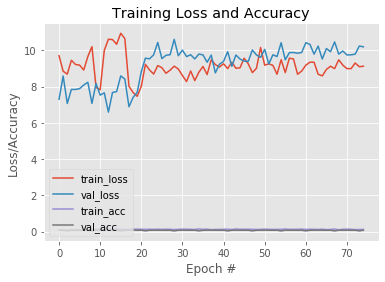

<Figure size 432x288 with 0 Axes>

In [0]:
BATCH_SIZE = 16
# Evaluer le modele juste apres avoir entrainer 
print("[INFO] evaluating after training network head...")
test_iterator.reset()
predIdxs = NasNetMobile_fine_tuned_without_first_bloc.predict_generator(test_iterator, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
# afficher les performances de classification
print(classification_report(test_iterator.classes, predIdxs, target_names=test_iterator.class_indices.keys()))
plot_training(H1, 75, TRAINING_HISTORY_PLOT_PATH_WITHOUT_FIRST_BLOC)

train_iterator.reset()
test_iterator.reset()

In [0]:
NasNetMobile_fine_tuned_without_first_bloc.save(MODEL_PATH_WITHOUT_FIRST_BLOC)

**GridSearch Evaluation finetuned Model without the first bloc and all the rest of layers are trainable!**

In [0]:
# Fonction pour creer le modele Keras
def define_model_NasNetMobile_fine_tuned_without_first_bloc():
  classes = 12
  NasNetMobile_fine_tuned_without_first_bloc = NasNetMobile_fine_tuned
  for layer in NasNetMobile_fine_tuned_without_first_bloc.layers[122:]:
    layer.trainable = True
  print("[INFO] compiling model...")
  opt = SGD(lr=1e-4, momentum=0.9)
  NasNetMobile_fine_tuned_without_first_bloc.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
  return NasNetMobile_fine_tuned_without_first_bloc 

model = KerasClassifier(build_fn = define_model_NasNetMobile_fine_tuned_without_first_bloc, verbose=1) 
# parametres de la grille de recherche
grid_param = {'batch_size' : [8, 16],
              'epochs' : [75, 100, 150]}
grid_search = GridSearchCV(estimator=model, param_grid=grid_param, cv=3)
grid_result = grid_search.fit(x_train, y_train)
# afficher les resultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# afficher les resultats detailles
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("mean (+/- std) = %f (%f) with: %r" % (mean, stdev, param))

**Geler les deux premièrs blocs et faire un fine-tuning sur les couches supérieures**

In [0]:
print("[INFO] loading model...")
model_NasNet_fine_tuned_without_first_bloc = load_model('/content/drive/My Drive/NasNet Models/mNasNet Model WITHOUT FIRST BLOC.model')

[INFO] loading model...


In [0]:
# -----------------------------------------------------------------
# a ce stade la FC est entrainée sur la nouvelle base.
# on va re-entrianer tout le réseau, càd toutes les couches
# 2*conv; 2*conv; 3*conv; 3*conv; 3*conv:
model_NasNet_fine_tuned_without_two_first_bloc = model_NasNet_fine_tuned_without_first_bloc
# Geler les deux premiers bloc
for layer in model_NasNet_fine_tuned_without_two_first_bloc.layers[215:]:
  layer.trainable = True

# visualiser les couches à entrainer
for layer in model_NasNet_fine_tuned_without_two_first_bloc.layers:
    print("{}: {}".format(layer, layer.trainable))

# apres ces changements, on doit recompiler le modele pour qu'il les prennent en considération
# on utilise un optimizer SGD avec un taux d'apprentissage tres faible au debut
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model_NasNet_fine_tuned_without_two_first_bloc.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [0]:
# entrainer la couche FC pour 50 epoch (rappel: toutes les autres couches sont gelees donc leurs poids resteront
# inchangés
BATCH_SIZE = 16
print("[INFO] training head...")
H2 = model_NasNet_fine_tuned_without_two_first_bloc.fit_generator(train_iterator, steps_per_epoch=totalTrain // BATCH_SIZE,
                        validation_data=test_iterator,
                        validation_steps=totalTest // BATCH_SIZE,
                        epochs=75)

[INFO] evaluating after training network head...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

         alder       0.00      0.00      0.00        17
         beech       0.00      0.00      0.00        15
         birch       0.00      0.00      0.00        18
      chestnut       0.00      0.00      0.00        16
 ginkgo-biloba       0.00      0.00      0.00        15
      hornbeam       0.00      0.00      0.00        15
horse-chestnut       0.00      0.00      0.00        16
        linden       0.00      0.00      0.00        15
           oak       0.08      1.00      0.15        15
oriental-plane       0.00      0.00      0.00        16
          pine       0.00      0.00      0.00        15
        spruce       0.00      0.00      0.00        22

      accuracy                           0.08       195
     macro avg       0.01      0.08      0.01       195
  weighted avg       0.01      0.08      0.01       195



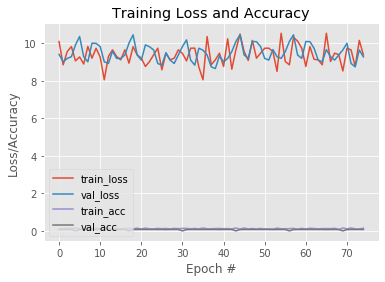

<Figure size 432x288 with 0 Axes>

In [0]:
BATCH_SIZE = 16
# Evaluer le modele juste apres avoir entrainer 
print("[INFO] evaluating after training network head...")
test_iterator.reset()
predIdxs = model_NasNet_fine_tuned_without_two_first_bloc.predict_generator(test_iterator, steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
# afficher les performances de classification
print(classification_report(test_iterator.classes, predIdxs, target_names=test_iterator.class_indices.keys()))
plot_training(H2, 75, TRAINING_HISTORY_PLOT_PATH_WITHOUT_TWO_FIRST_BLOC)

train_iterator.reset()
test_iterator.reset()

In [0]:
model_NasNet_fine_tuned_without_two_first_bloc.save(MODEL_PATH_WITHOUT_TWO_FIRST_BLOC)

**GridSearch Evaluation finetuned Model without the TWO first blo and all the rest of layers are trainable!**

In [0]:
# Fonction pour creer le modele Keras
def define_model_NasNet_fine_tuned_without_two_first_bloc():
  classes = 12
  model_NasNet_fine_tuned_without_two_first_bloc = model_NasNet_fine_tuned_without_first_bloc
  # Geler les deux premiers bloc
  for layer in model_NasNet_fine_tuned_without_two_first_bloc.layers[215:]:
    layer.trainable = True

  print("[INFO] compiling model...")
  opt = SGD(lr=1e-4, momentum=0.9)
  model_NasNet_fine_tuned_without_two_first_bloc.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
  return model_NasNet_fine_tuned_without_two_first_bloc 

model_ResNet34_fine_tuned_without_two_first_bloc = KerasClassifier(build_fn=define_model_NasNet_fine_tuned_without_two_first_bloc, verbose=1) 
# parametres de la grille de recherche
grid_param = {'batch_size' : [8, 16],
              'epochs' : [75, 100, 150]}
grid_search = GridSearchCV(estimator=model_ResNet34_fine_tuned_without_two_first_bloc, param_grid=grid_param, cv=3)
grid_result = grid_search.fit(x_train, y_train)
# afficher les resultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# afficher les resultats detailles
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("mean (+/- std) = %f (%f) with: %r" % (mean, stdev, param))

In [0]:
print("[INFO] loading model...")
model_NasNet_fine_tuned = load_model('/content/drive/My Drive/NasNet Models/mNasNet Model FINE TUNING.model')

[INFO] loading model...


In [0]:
# initialiser un objet LabelEncoder
le = None
# parcourir les repo train et test
for split in (TRAIN, TEST):
    # charger les images
    print("[INFO] processing '{} split'...".format(split))
    p = os.path.sep.join([BASE_PATH, split])
    imagePaths = list(paths.list_images(p))

    # extraire les labels des classes à partir du chemin
    random.shuffle(imagePaths)
    labels = [p.split(os.path.sep)[-2] for p in imagePaths]

    # creer un objet LabelEncoder
    # qui va encoder les label avec des valeur entre 0 and nbr_class-1.
    if le is None:
        le = LabelEncoder()
        le.fit(labels)

    # ouvrir le fichier csv en mode ecriture
    csvPath = os.path.sep.join([BASE_CSV_PATH, "{}.csv".format(split)])
    csv = open(csvPath, "w")
    # parcourir les images en batch
    for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
        print("[INFO] processing batch {}/{}".format(b + 1, int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
        # former des batch avec le chemin des images et leurs labels
        batchPaths = imagePaths[i:i + BATCH_SIZE]
        batchLabels = le.transform(labels[i:i + BATCH_SIZE])
        # initialiser la liste des images qu'on va passer dans le CNN pour l'extraction de caracteristiques
        batchImages = []
        # loop over the images and labels in the current batch
        for imagePath in batchPaths:
            # charger l'image en taille 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            # image => tensor
            image = np.expand_dims(image, axis=0)
            # normalisation
            #image = imagenet_utils.preprocess_input(image)
            # ajouter l'image au batch
            batchImages.append(image)
        # passer l'image le long du CNN, extraire les caractéristiques et les representer comme vecteur
        batchImages = np.vstack(batchImages)
        model_extract = Model(model_NasNet_fine_tuned.inputs, model_NasNet_fine_tuned.layers[-2].output)
        features = model_extract.predict(batchImages, batch_size=BATCH_SIZE)
        features = features.reshape((features.shape[0], 1056))
        # sauvegarder "label, vecteur de caractéristiques" dans le fichiers CSV
        for (label, vec) in zip(batchLabels, features):
            vec = ",".join([str(v) for v in vec])
            csv.write("{},{}\n".format(label, vec))

    # fermer le fichier CSV
    csv.close()


In [0]:
print("[INFO] loading model...")
model_NasNet_fine_tuned_without_first_bloc = load_model('/content/drive/My Drive/NasNet Models/mNasNet Model WITHOUT FIRST BLOC.model')

In [0]:
# initialiser un objet LabelEncoder
le = None
# parcourir les repo train et test
for split in (TRAIN, TEST):
    # charger les images
    print("[INFO] processing '{} split'...".format(split))
    p = os.path.sep.join([BASE_PATH, split])
    imagePaths = list(paths.list_images(p))

    # extraire les labels des classes à partir du chemin
    random.shuffle(imagePaths)
    labels = [p.split(os.path.sep)[-2] for p in imagePaths]

    # creer un objet LabelEncoder
    # qui va encoder les label avec des valeur entre 0 and nbr_class-1.
    if le is None:
        le = LabelEncoder()
        le.fit(labels)

    # ouvrir le fichier csv en mode ecriture
    csvPath = os.path.sep.join([BASE_CSV_PATH, "{}.csv".format(split)])
    csv = open(csvPath, "w")
    # parcourir les images en batch
    for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
        print("[INFO] processing batch {}/{}".format(b + 1, int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
        # former des batch avec le chemin des images et leurs labels
        batchPaths = imagePaths[i:i + BATCH_SIZE]
        batchLabels = le.transform(labels[i:i + BATCH_SIZE])
        # initialiser la liste des images qu'on va passer dans le CNN pour l'extraction de caracteristiques
        batchImages = []
        # loop over the images and labels in the current batch
        for imagePath in batchPaths:
            # charger l'image en taille 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            # image => tensor
            image = np.expand_dims(image, axis=0)
            # normalisation
            #image = imagenet_utils.preprocess_input(image)
            # ajouter l'image au batch
            batchImages.append(image)
        # passer l'image le long du CNN, extraire les caractéristiques et les representer comme vecteur
        batchImages = np.vstack(batchImages)
        model_extract = Model(model_NasNet_fine_tuned_without_first_bloc.inputs, model_NasNet_fine_tuned_without_first_bloc.layers[-2].output)
        features = model_extract.predict(batchImages, batch_size=BATCH_SIZE)
        features = features.reshape((features.shape[0], 1056))
        # sauvegarder "label, vecteur de caractéristiques" dans le fichiers CSV
        for (label, vec) in zip(batchLabels, features):
            vec = ",".join([str(v) for v in vec])
            csv.write("{},{}\n".format(label, vec))

    # fermer le fichier CSV
    csv.close()


[INFO] processing 'Trunk12_resized_train split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13
[INFO] processing 'Trunk12_resized_test split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13


In [0]:
print("[INFO] loading model...")
model_NasNet_fine_tuned_without_two_first_bloc = load_model('/content/drive/My Drive/NasNet Models/mNasNet Model WITHOUT TWO FIRST BLOC.model')

[INFO] loading model...


In [0]:
# initialiser un objet LabelEncoder
le = None
# parcourir les repo train et test
for split in (TRAIN, TEST):
    # charger les images
    print("[INFO] processing '{} split'...".format(split))
    p = os.path.sep.join([BASE_PATH, split])
    imagePaths = list(paths.list_images(p))

    # extraire les labels des classes à partir du chemin
    random.shuffle(imagePaths)
    labels = [p.split(os.path.sep)[-2] for p in imagePaths]

    # creer un objet LabelEncoder
    # qui va encoder les label avec des valeur entre 0 and nbr_class-1.
    if le is None:
        le = LabelEncoder()
        le.fit(labels)

    # ouvrir le fichier csv en mode ecriture
    csvPath = os.path.sep.join([BASE_CSV_PATH, "{}.csv".format(split)])
    csv = open(csvPath, "w")
    # parcourir les images en batch
    for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
        print("[INFO] processing batch {}/{}".format(b + 1, int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
        # former des batch avec le chemin des images et leurs labels
        batchPaths = imagePaths[i:i + BATCH_SIZE]
        batchLabels = le.transform(labels[i:i + BATCH_SIZE])
        # initialiser la liste des images qu'on va passer dans le CNN pour l'extraction de caracteristiques
        batchImages = []
        # loop over the images and labels in the current batch
        for imagePath in batchPaths:
            # charger l'image en taille 224x224 pixels
            image = load_img(imagePath, target_size=(224, 224))
            image = img_to_array(image)
            # image => tensor
            image = np.expand_dims(image, axis=0)
            # normalisation
            #image = imagenet_utils.preprocess_input(image)
            # ajouter l'image au batch
            batchImages.append(image)
        # passer l'image le long du CNN, extraire les caractéristiques et les representer comme vecteur
        batchImages = np.vstack(batchImages)
        model_extract = Model(model_NasNet_fine_tuned_without_two_first_bloc.inputs, model_NasNet_fine_tuned_without_two_first_bloc.layers[-2].output)
        features = model_extract.predict(batchImages, batch_size=BATCH_SIZE)
        features = features.reshape((features.shape[0], 1056))
        # sauvegarder "label, vecteur de caractéristiques" dans le fichiers CSV
        for (label, vec) in zip(batchLabels, features):
            vec = ",".join([str(v) for v in vec])
            csv.write("{},{}\n".format(label, vec))

    # fermer le fichier CSV
    csv.close()


[INFO] processing 'Trunk12_resized_train split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13
[INFO] processing 'Trunk12_resized_test split'...
[INFO] processing batch 1/13
[INFO] processing batch 2/13
[INFO] processing batch 3/13
[INFO] processing batch 4/13
[INFO] processing batch 5/13
[INFO] processing batch 6/13
[INFO] processing batch 7/13
[INFO] processing batch 8/13
[INFO] processing batch 9/13
[INFO] processing batch 10/13
[INFO] processing batch 11/13
[INFO] processing batch 12/13
[INFO] processing batch 13/13
